In [1]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

/home/lgervasoni/anaconda2/envs/urbansprawl/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import extract_uses.parameters as parameters
import extract_uses.utils as utils

# City to download: Grenoble
city_country = "grenoble_france"#"grenoble_france"
citiesFolder = 'cities/'
# Population count file
popu_count_file = "/home/lgervasoni/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2000/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2000.tif"

# Get the required cities shapefile
utils.getCityShapefile(citiesFolder, [ city_country ])

# Set input files
parameters.setInputFiles(citiesFolder, city_country, popu_count_file, numberOfCuts = 16)
#parameters.setInputFiles(citiesFolder, city_country, popu_count_file = None, numberOfCuts = 16)

('Existing shapefile for', 'grenoble_france')


In [3]:
import extract_uses.main

extract_uses.main.process()

('Folder already exists. Assumption: Already processed. Only mapping categories and exiting.', 'cities/grenoble_france/')
Complete processing: --- 0.39053418239 minutes ---


In [195]:
import loaders

import extract_uses.utils as utils

uses_shp = citiesFolder+city_country+"/full_uses.shp"
bbox = utils.getBoundingBox(uses_shp)

geo_graph = loaders.load_graph(city_country, bbox)
pois_df = loaders.load_pois(city_country, uses_shp)
#centrality_df = loaders.load_graph_centrality(city_country, geo_graph)
#kde_df = loaders.load_graph_kde(city_country, geo_graph, pois_df)

# Grid KDE
grid_step = .0015
categories_kde = loaders.load_grid_kde(city_country, pois_df, bbox = bbox, grid_step = grid_step)

('Bounding box:', [45.113017726416615, 5.573125356566398, 45.243980680751875, 5.9029513504478865])
Querying locally for `['nodes', 'edges']`
Found ['nodes', 'edges'] stored locally
Querying locally for `['pois']`
Found ['pois'] stored locally
Querying locally for `['activity', 'residential', 'total']`
Found ['activity', 'residential', 'total'] stored locally


In [ ]:
import kde

import numpy as np
import pandas as pd
from seaborn.distributions import _statsmodels_bivariate_kde
from six import string_types
from sklearn.neighbors.kde import KernelDensity
import statsmodels.nonparametric.api as smnp

grid_step = .0015

def _kde(x, y, grid, option):
    if (option == 1):
        bw_func = smnp.bandwidths.bw_scott #scott
    if (option == 2):
        bw_func = smnp.bandwidths.bw_silverman #silverman   
    #TODO: Check other option; normal_reference: normal reference rule of thumb (default), cv_ml: cross validation maximum likelihood, cv_ls: cross validation least squares
    if (option <= 2):
        kde = smnp.KDEMultivariate([x, y], "cc", [bw_func(x), bw_func(y)])
    if (option == 3):
        kde = smnp.KDEMultive
        ariate([x, y], "cc", 'cv_ml')
    if (option == 4):
        kde = smnp.KDEMultivariate([x, y], "cc", 'cv_ls')    
    return kde.pdf([grid[0].ravel(), grid[1].ravel()]).reshape(grid[0].shape)
def _get_grid_kde(pois,grid,option):
    return _kde(pois['lon'].values, pois['lat'].values, grid, option)
def get_grid_all_kde(pois, bbox, grid_step,option):
    kde_dict = {}
    grid = utils.grid_from_bbox(bbox, grid_step)
    for category, items in pois.groupby(by=['category']):
        kde_dict[category] = pd.DataFrame(_get_grid_kde(items, grid,option))
    kde_dict['total'] = pd.DataFrame(_get_grid_kde(pois, grid,option))
    return kde_dict


### Send bw_func, and cv_ml or cv_ls ?
#http://statsmodels.sourceforge.net/devel/nonparametric.html#kernel-density-estimation

categories_kde_scott = get_grid_all_kde(pois_df,bbox,grid_step, 1)
#categories_kde_silverman = get_grid_all_kde(pois_df,bbox,grid_step, 2)
#categories_kde_cv_ml = get_grid_all_kde(pois_df,bbox,grid_step, 3)
#categories_kde_cv_ls = get_grid_all_kde(pois_df,bbox,grid_step, 4)

#kde_all = [ categories_kde_scott, categories_kde_silverman, categories_kde_cv_ml, categories_kde_cv_ls ]
kde_all = [ categories_kde_scott ]

In [284]:
categories_kde = kde_all[0]

In [285]:
print( categories_kde.keys() )
keys = list(map(lambda cat : 'kde_' + str(cat), categories_kde.keys()))

import pandas as pd
dfs = list(map(pd.DataFrame, categories_kde.values()))

ser = pd.Series(categories_kde.values(), index=list(map(str, categories_kde.keys())))
ser

['residential', 'activity']


residential              0          1          2          3  ...
activity                    0             1             2    ...
dtype: object

In [286]:
print('Keys:',keys)
#print('Dfs:',dfs)

with pd.HDFStore(loaders._generate_file_path(city_country), 'a') as store:
    for key, df in zip(keys, dfs):
        store.put(key, df, format='table')

('Keys:', ['kde_residential', 'kde_activity'])


In [287]:
import pickle
# TODO: create a `loaders` method for `category_kde`
with open('categories_kde.p', 'wb') as f:
    pickle.dump(categories_kde, f)

In [288]:
### Normalise to [0,1] all cells of KDE

def applyDiv(x,total):
    return x/total
applyNormalisation = np.vectorize(applyDiv)

np_kde_activities = np.matrix(ser.activity)
total_sum = np_kde_activities.sum()
num_elements = np_kde_activities.shape[0] * np_kde_activities.shape[1]
ratio = total_sum / num_elements

print('Kde activities')
print('Total sum:',total_sum)
print('Num elements:',num_elements)
print('Ratio:',ratio)

np_kde_residential = np.matrix(ser.residential)
total_sum = np_kde_residential.sum()
num_elements = np_kde_residential.shape[0] * np_kde_residential.shape[1]
ratio = total_sum / num_elements

print('Kde residential')
print('Total sum:',total_sum)
print('Num elements:',num_elements)
print('Ratio:',ratio)

norm_kde_act = applyNormalisation(np_kde_activities, np_kde_activities.sum())
norm_kde_res = applyNormalisation(np_kde_residential, np_kde_residential.sum())

print('Act: Sum of elements:',norm_kde_act.sum())
print('Res: Sum of elements:',norm_kde_res.sum())

kde_activities = norm_kde_act
kde_residential = norm_kde_res

def plot_(xx,yy,to_plot,name):
    fig_size = (12,5)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(xx,yy,to_plot , cmap=cm.RdYlBu)
    ax.set_zlabel(name)

Kde activities
('Total sum:', 441099.98722950759)
('Num elements:', 19360)
('Ratio:', 22.784090249458036)
Kde residential
('Total sum:', 435888.51315022702)
('Num elements:', 19360)
('Ratio:', 22.514902538751397)
('Act: Sum of elements:', 0.99999999999999989)
('Res: Sum of elements:', 1.0)


In [301]:
"""
import numpy

#http://stackoverflow.com/questions/9002715/how-to-calculate-the-estimated-joint-probability-distribution-for-the-red-and-gr
#2d histogram gives you the counts, in each cell
(H,redEdges,greedEdges) = numpy.histogram2d(
    norm_kde_act.ravel(),norm_kde_res.ravel(),
    bins= 10#(norm_kde_act.shape[0] * norm_kde_act.shape[1])
)

#divide by the total to get the probability of 
#each cell -> the joint distribution
Prg = H/H.sum()

#sum over the `green` axis to get the `red` marginal (nx1)
Pr = H2d.sum(1)[:,numpy.newaxis]
#sum over the `red` axis to get the `green` marginal (1xn) 
Pg = H2d.sum(0)[numpy.newaxis,:]

# Mutual information ?
"""

'\nimport numpy\n\n#http://stackoverflow.com/questions/9002715/how-to-calculate-the-estimated-joint-probability-distribution-for-the-red-and-gr\n#2d histogram gives you the counts, in each cell\n(H,redEdges,greedEdges) = numpy.histogram2d(\n    norm_kde_act.ravel(),norm_kde_res.ravel(),\n    bins= 10#(norm_kde_act.shape[0] * norm_kde_act.shape[1])\n)\n\n#divide by the total to get the probability of \n#each cell -> the joint distribution\nPrg = H/H.sum()\n\n#sum over the `green` axis to get the `red` marginal (nx1)\nPr = H2d.sum(1)[:,numpy.newaxis]\n#sum over the `red` axis to get the `green` marginal (1xn) \nPg = H2d.sum(0)[numpy.newaxis,:]\n\n# Mutual information ?\n'

In [302]:
import numpy as np
lu_mix_entropy = np.zeros(shape=kde_activities.shape)
lu_mix_balance_index = np.zeros(shape=kde_activities.shape)
lu_mix = np.zeros(shape=kde_activities.shape)
rows, cols = lu_mix.shape[0] , lu_mix.shape[1]

def compute_phi(x,y):
    #return abs(x-y)
    return abs(x-y)**0.75
    #return abs(x-y) * max(x,y)
    #return abs(x-y) * min(1,x+y)
    #return (1 - ( abs(x-y)**0.1 ) ) * min(1,x+y)
    #return (1 - ( abs(x-y)**0.5 ) ) * max(x,y)

def compute_phi_entropy(x,y):
    import math
    #https://www.wolframalpha.com/input/?i=plot+z+%3D+-+(+(+x*ln(x)+)+%2B+(+y*ln(y)+)+)+%2F+ln(2),+x%3D0..1
    return - ( ( x*math.log(x) ) + ( y*math.log(y) ) ) / math.log(2)

def compute_phi_balance_index(x,y):
    #https://www.wolframalpha.com/input/?i=plot+z%3D+1-+(abs(x-y))%2F(x%2By)+,+x%3D0..1
    return 1 - (abs(x-y))/(x+y)

In [303]:
for i in range(rows): #Rows
    for j in range(cols): #Cols
        lu_mix_entropy[i,j] = compute_phi_entropy(kde_activities[i,j] , kde_residential[i,j])
        
for i in range(rows): #Rows
    for j in range(cols): #Cols
        lu_mix_balance_index[i,j] = compute_phi_balance_index(kde_activities[i,j] , kde_residential[i,j])

for i in range(rows): #Rows
    for j in range(cols): #Cols
        lu_mix[i,j] = compute_phi(kde_activities[i,j] , kde_residential[i,j])
        
'''
phi = lu_mix.sum()
for i in range(rows): #Rows
    for j in range(cols): #Cols
        lu_mix[i,j] /= phi    
'''

'\nphi = lu_mix.sum()\nfor i in range(rows): #Rows\n    for j in range(cols): #Cols\n        lu_mix[i,j] /= phi    \n'

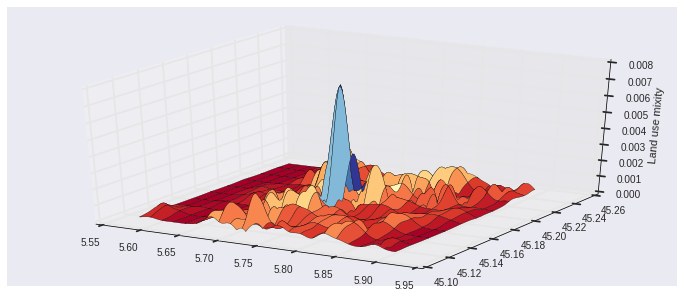

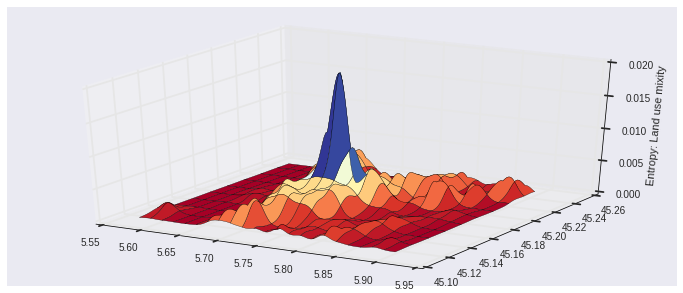

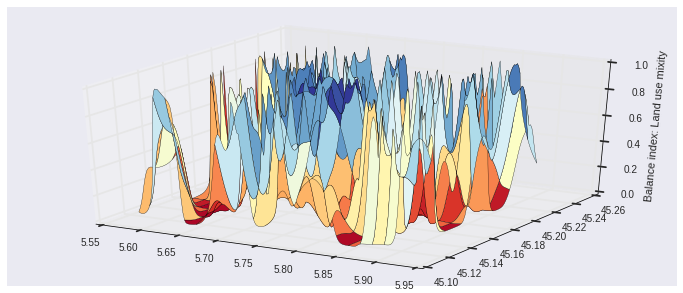

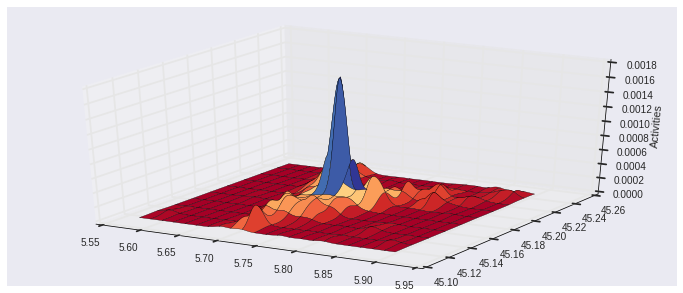

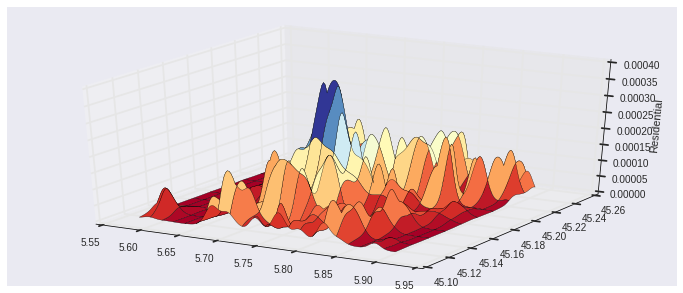

In [304]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils
%matplotlib inline
xx, yy = utils.grid_from_bbox(bbox,grid_step)
plot_(xx,yy,lu_mix,'Land use mixity')
plot_(xx,yy,lu_mix_entropy,'Entropy: Land use mixity')
plot_(xx,yy,lu_mix_balance_index,'Balance index: Land use mixity')
plot_(xx,yy,kde_activities,'Activities')
plot_(xx,yy,kde_residential,'Residential')
plt.show()

In [ ]:
# Grid containing num of activities / residential points
# Relative to the total number for each category?

#Act_grid = utils.grid_from_bbox(bbox, grid_step)
#Res_grid = utils.grid_from_bbox(bbox, grid_step)

#Act_grid[0,0]



In [41]:
import numpy as np

""" Plotting functions
Be careful: When x==y
https://www.wolframalpha.com/input/?i=plot+z+%3D+(1+-+abs(x-y)+)*max(x,y),+x%3D0..1
https://www.wolframalpha.com/input/?i=plot+z+%3D+(1+-+abs(x-y)+)*max(x,y)%5E0.5,+x%3D0..1
"""

phi = 0
categories_list = categories_kde.items()
# let: n be the total number of categories; l be the total number of grid (lattice) points
n = len(categories_list[0][0])
l = len(categories_list[0][1])**2 # TODO: more `correct` GRIDSIZE handling
# [[phi += np.sum(vi - vj) for j, (kj, vj) in enumerate(categories_list[i:])] for i, (ki, vi) in enumerate(categories_list)]

for i, (ki, vi) in enumerate(categories_list):
    for j, (kj, vj) in enumerate(categories_list[i:]):
        phi += np.sum(vi - vj) # here i would divide it by l, but computationally i can do that at the end

phi_mix = phi / l # (l * n * (n-1) * .5)

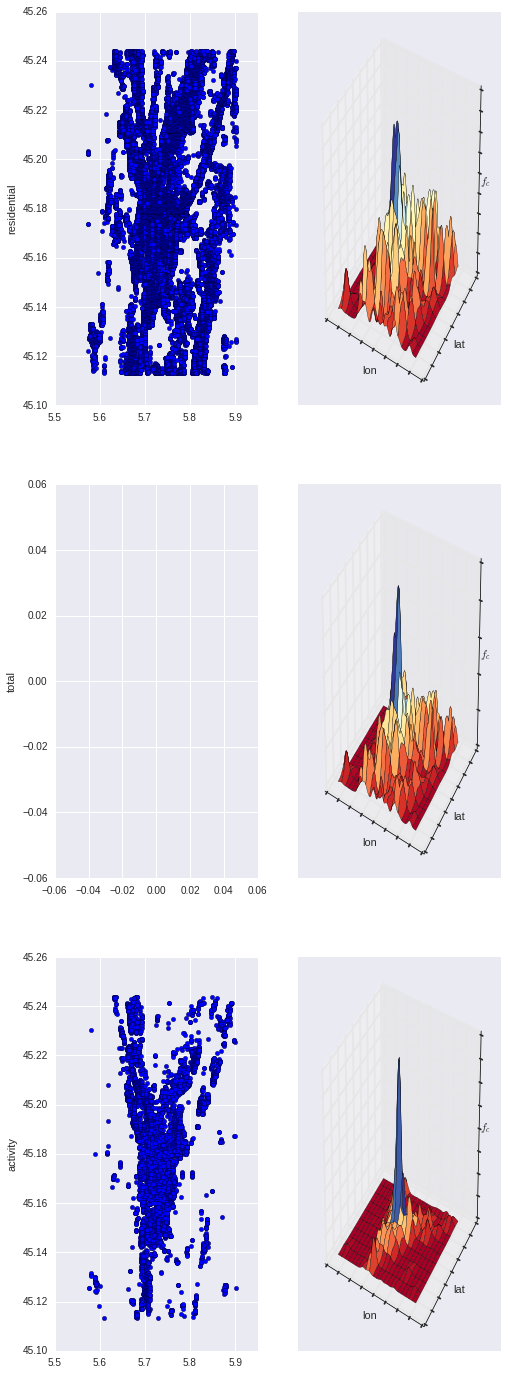

In [51]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils

%matplotlib inline
n_rows = len(categories_kde)
base_figsize = 8
xx, yy = utils.grid_from_bbox(bbox,grid_step)

fig = plt.figure(figsize=(8, 8 * n_rows))
i = 1
for categories_kde in kde_all:
    print('---------------')
    for label, z in categories_kde.items():
        category_pois = pois_df[pois_df['category'] == label]
        ax1 = fig.add_subplot(n_rows, 2, i)
        ax2 = fig.add_subplot(n_rows, 2, i+1, projection='3d')
        ax1.scatter(category_pois['lon'], category_pois['lat'])
        ax1.set_ylabel(label, rotation=90)
        ax2.plot_surface(xx, yy, z, cmap=cm.RdYlBu)
        i += 2
        ax2.set_xlabel('lon', labelpad=-10)
        ax2.set_ylabel('lat', labelpad=-10)
        ax2.zaxis.set_rotate_label(False) # workaround
        ax2.set_zlabel(r'$f_c$', rotation=0, labelpad=-15)
        ax2.w_xaxis.set_ticklabels([])
        ax2.w_yaxis.set_ticklabels([])
        ax2.w_zaxis.set_ticklabels([])
    
plt.show()